#  Прогнозирование заказов такси

**Объект исследования:**  
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.

**Цель:**  
Расработать модель прогнозирования количества заказов такси на следующий час, тем самым привлекать больше водителей в период пиковой нагрузки.

**Задача:**   
На основании исторических данных построить модель машинного обучения для предсказания количество заказов такси на следующий час.  
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-и-знакомство-с-данными" data-toc-modified-id="Загрузка-и-знакомство-с-данными-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и знакомство с данными</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Изучение-тренда-и-сезонности" data-toc-modified-id="Изучение-тренда-и-сезонности-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Изучение тренда и сезонности</a></span></li><li><span><a href="#Выбросы-и-аномальные-значения" data-toc-modified-id="Выбросы-и-аномальные-значения-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Выбросы и аномальные значения</a></span></li><li><span><a href="#Корреляция-и-новые-признаки" data-toc-modified-id="Корреляция-и-новые-признаки-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Корреляция и новые признаки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия-с-регуляризацией-Elasticnet" data-toc-modified-id="Линейная-регрессия-с-регуляризацией-Elasticnet-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Линейная регрессия с регуляризацией Elasticnet</a></span></li><li><span><a href="#Градиентный-бустинг-CatBoost" data-toc-modified-id="Градиентный-бустинг-CatBoost-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Градиентный бустинг CatBoost</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Важность-признаков" data-toc-modified-id="Важность-признаков-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Важность признаков</a></span></li></ul></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоги</a></span></li></ul></div>

## Подготовка
### Импорт библиотек

In [ ]:
# установка библиотеки catboost
# !pip install catboost

In [2]:
# импорт необходимых библиотек
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# тест дики - Фуллера для проверки стационарности ряда
from statsmodels.tsa.stattools import adfuller

# декомпозиция временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose

# поиск выбросов
from sklearn.ensemble import IsolationForest

# для коэффициента корреляции фи 
#import phik

# деление на выборки
from sklearn.model_selection import train_test_split, TimeSeriesSplit, learning_curve

# метрика качества
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# подбор гипрепараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score


# линейные модели
from sklearn.linear_model import ElasticNet, LinearRegression

# модель случайный лес
from sklearn.ensemble import RandomForestRegressor

# модель градиентный бустинг из библиотеки catboost
import catboost as cb

# скрыть предупреждения
import warnings
warnings.filterwarnings('ignore')

### Загрузка и знакомство с данными

In [3]:
# откроем файл с историчекими данными
# возможные пути расположения файла
server_path = '/datasets/taxi.csv'
local_path = 'taxi.csv'

if os.path.exists(server_path):
    df_original = pd.read_csv(server_path, index_col=[0], parse_dates=[0]) # столбец с датой сделали индексом, тип данных
elif os.path.exists(local_path):
    df_original = pd.read_csv(local_path, index_col=[0], parse_dates=[0])
else:
    'Неправильно указан путь к файлу'

In [4]:
# запишем датафрейм для работы, сохранив исходный, и посмотрим
df = df_original.copy()
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


В предоставленном датафрейме 26 496 объектов и 1 признак:
- `num_orders` - количество заказов такси  

В качестве индекса задали дату - интервалы по 10 минут.


In [5]:
# посмотрим пропуски и типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# прверим порядок дат и времени
df.index.is_monotonic

True

- В данных нет пропусков
- Типы данных корректные
- Временной период данных 6 месяцев 2018-03-01 - 2018-08-31. Объекты расположены в хронологичесвком порядке.

Визуализируем временной ряд.

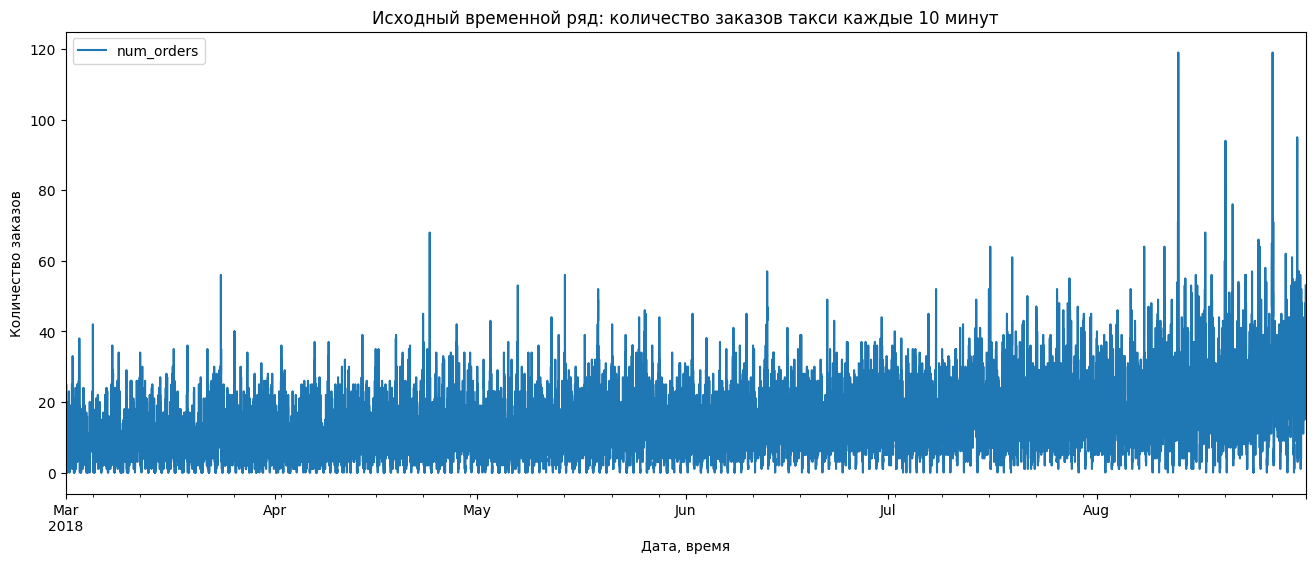

In [7]:
# график количества заказов от вермени
df.plot(figsize=(16,6),
        title=('Исходный временной ряд: количество заказов такси каждые 10 минут'), 
        xlabel=('Дата, время'),
        ylabel=('Количество заказов'))
None

Мы видим увеличение числа заказов в конце периода и выбросы, также сконцентрированные в конце - в августе. На первый взгляд временной ряд нестационарный.

Предоставленные данные полные, на первый взгляд выглядят правдоподобно, типы данных подходящие.

## Анализ

Перед нами стоит задача прогнозирования количества заказов такси на час вперёд, поэтому сделаем ресэмплирование данных по каждому часу с суммами заказов.

In [8]:
# пересохраним датафрейм с ресэмплингом по 1 часу
df = df.resample('1H').sum()
# проверка
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
# распределение в исходном и сэмплированном датасетах
pd.concat([df_original.describe(), df.describe()], axis=1, keys=['10M', '1H'])

,10M,1H
,num_orders,num_orders
count,26496.000000,4416.000000
mean,14.070463,84.422781
std,9.211330,45.023853
min,0.000000,0.000000
25%,8.000000,54.000000
50%,13.000000,78.000000
75%,19.000000,107.000000
max,119.000000,462.000000


- Теперрь датасет состоит из 4 416 объектов. 
- У нас есть часы, в которых не было ни одного заказа
- Максимум 462 заказа час, в среднем 84

### Изучение тренда и сезонности

Построим график ресэмплированного распределения.  
Чтобы во временном ряду снизить колебания, применим скользящее среднее.


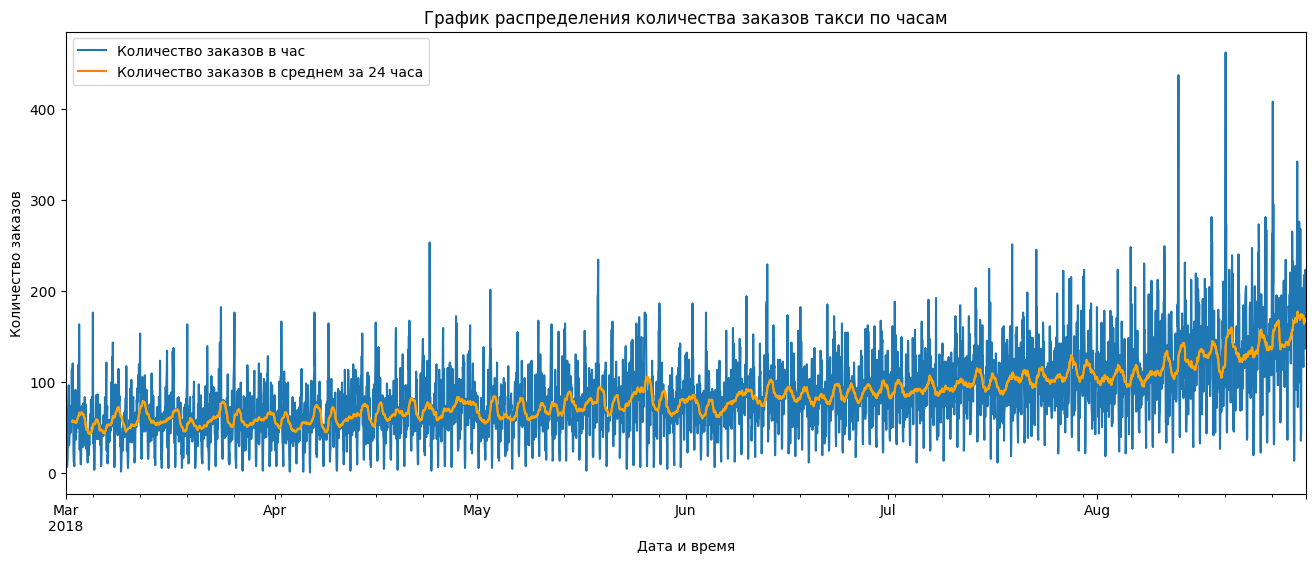

In [10]:
#  запишем в новый столбец скользящее среднее с шириной окна 1 сутки
df['rolling_mean_24'] = df.rolling(24).mean()

# построим график ресэмплированного временного ряда
df.plot(figsize=(16,6))
# график скользящего среднего
df['rolling_mean_24'].plot(color='orange')
plt.title('График распределения количества заказов такси по часам')
plt.ylabel('Количество заказов')
plt.xlabel('Дата и время')
plt.legend(['Количество заказов в час', 'Количество заказов в среднем за 24 часа'])
plt.show()

- Ряд имеет возрастающий тренд. Более быстрое повышение в августе
- Ряд нестационарный 
- Очевидные выбросы в конце ряда - в августе, прогнозирвоание которого мы планируем проверять в проекте.

В проекте рассматриваются заказы такси из аэропортов. Временной ряд демонстрирует повышение перелётов в летний отпускной сезон, а повышение в августе скорее всего связано с периодом возвращения перед началом учебного года.

**Исследование стационарности ряда: тест Дики-Фуллера (ADF)**

Так как по графику не всегда можно достоверно оценить стационарность ряда, используем статистический тест Дики - Фуллера.

Проверяем гипотезу, что ряд не стационарен:
```
H_0: Временной ряд не стационарен
H_1: Временной ряд стационарен
alpha = 0.01
alpha = 0.05
```

In [11]:
# выполнение теста Дики-Фуллера 
adf_result = adfuller(df['num_orders'])

# выведем результат статистики, p-value, критических значений
print('Критерий ADF: %f' % adf_result[0])

print('P-value: %f' % adf_result[1])

print('\nКритические значения:')

for key, value in adf_result[4].items():
    print(f'\t{key}: {value: .3f}')

# Проверим гипотезы с двумя уровнями значимости, 
# гипотеза не опровергается, если статистика больше критерия
for alpha in ['1%', '5%']:
    print(f'\nПри уровне значимости {alpha}:')
    if adf_result[0] < adf_result[4][alpha]:
        print("Нулевая гипотеза отвергнута – Временной ряд стационарен")
    else:
        print("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-value: 0.028940

Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567

При уровне значимости 1%:
Нулевая гипотеза не отвергнута – Временной ряд не стационарен

При уровне значимости 5%:
Нулевая гипотеза отвергнута – Временной ряд стационарен


Тест Дики-Фуллера при уровне значимости 1% не опровергает нашу гипотезу, что временной не стационарен. Но при 5% даёт обратный результат, то есть отвергает гипотизу и показывает, что ряд стационарен.


Сделаем декомпозицию ряда, оценим тренд, сезонность и шум.

In [12]:
# расложим ряд
decomposed = seasonal_decompose(df['num_orders'])

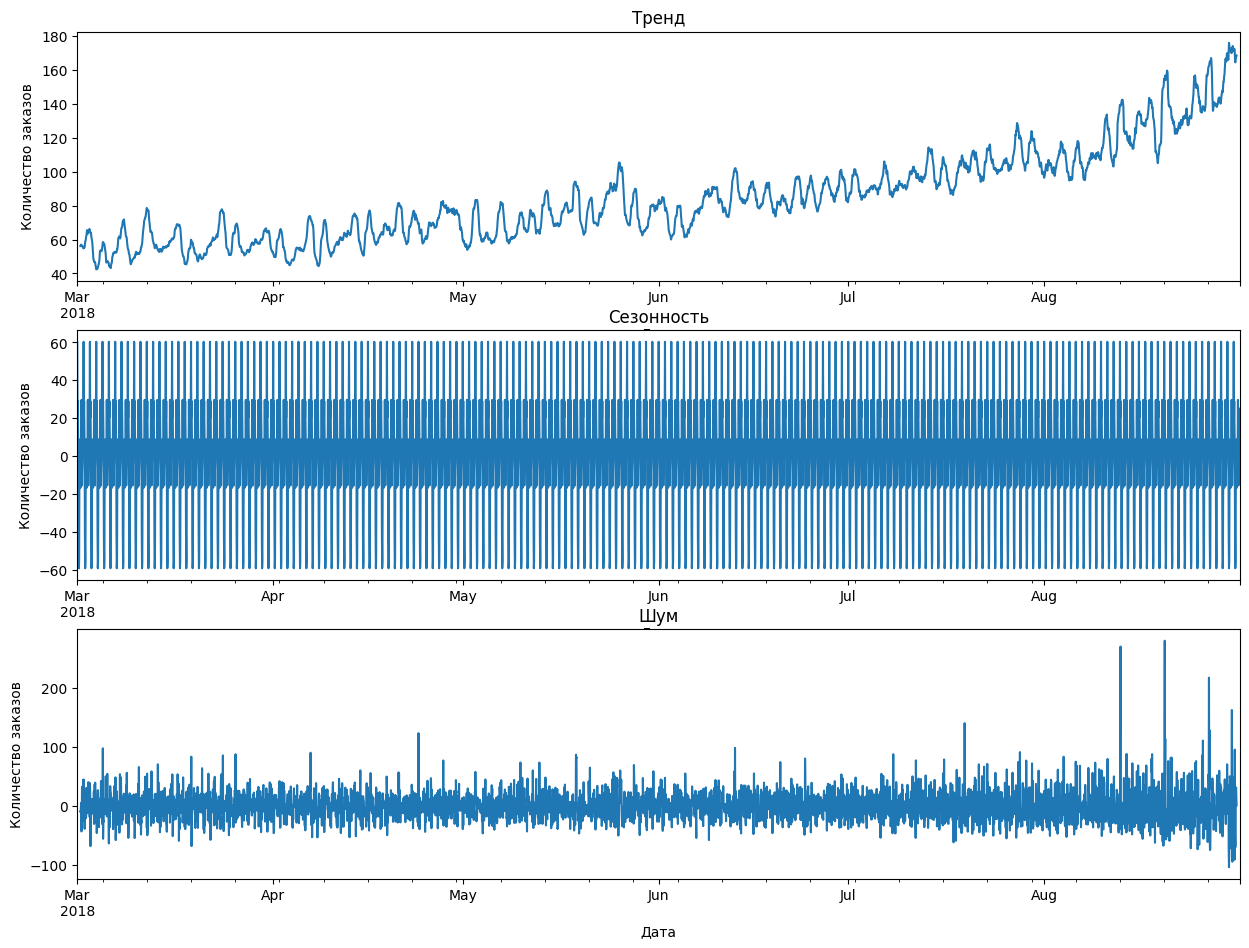

In [13]:
# построим графики разложенного ряда:
plt.figure(figsize=(15,11))
# тренд
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
# сезонность
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
# шум
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

- Подтверждаем возрастающий тренд

Так как в задаче рассматриваем спрос на такси у аэропорта, можем объяснить повышение в летний сезон - сезоном отпусков, а более резкое повышение в августе - периодом возвращения из отпусков перед началом учебного года.


- Имеется сезонность, возможно выражается в течение дня. Далее проанализируем, увеличив масштаб. 
- Выбросы остались в шуме

Посмотрим срез 1 недели

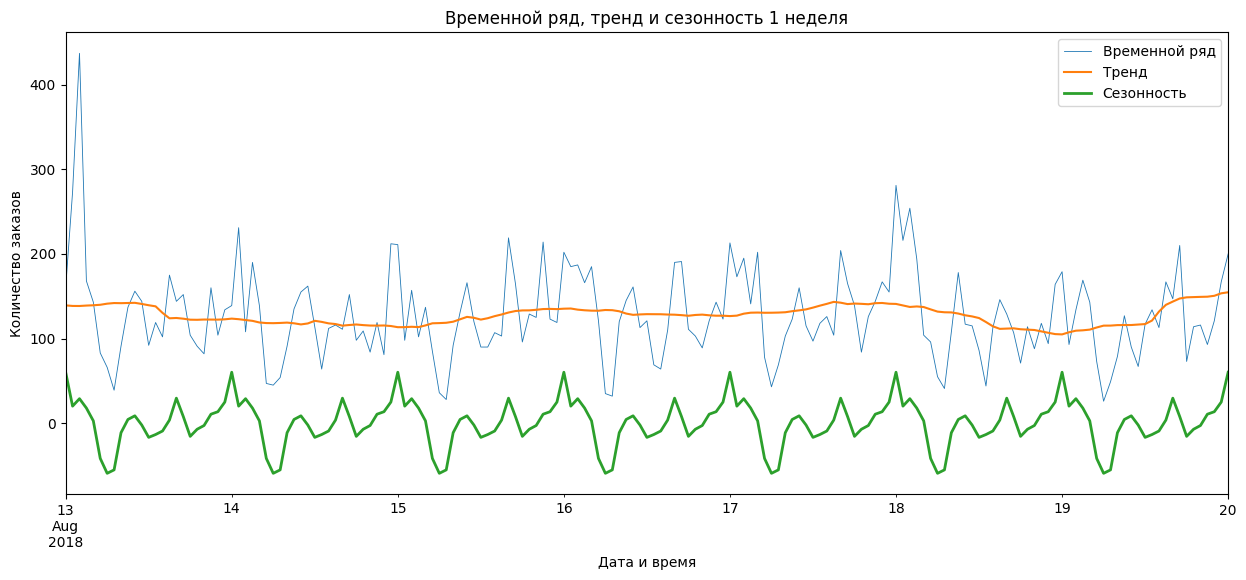

In [14]:
# выберем неделю с пн по вс в конце ряда в агусте
one_week = df['2018-08-13 00:00:00':'2018-08-20 00:00:00'].index
# построим графики
# временной ряд по часам
df.loc[one_week]['num_orders'].plot(linewidth=0.6)
# тренд
decomposed.trend[one_week].plot()
# сезонность
decomposed.seasonal[one_week].plot(figsize=(15,6), linewidth=2)
plt.title('Временной ряд, тренд и сезонность 1 неделя')
plt.legend(['Временной ряд', 'Тренд', 'Сезонность'])
plt.ylabel('Количество заказов')
plt.xlabel('Дата и время')

plt.show()

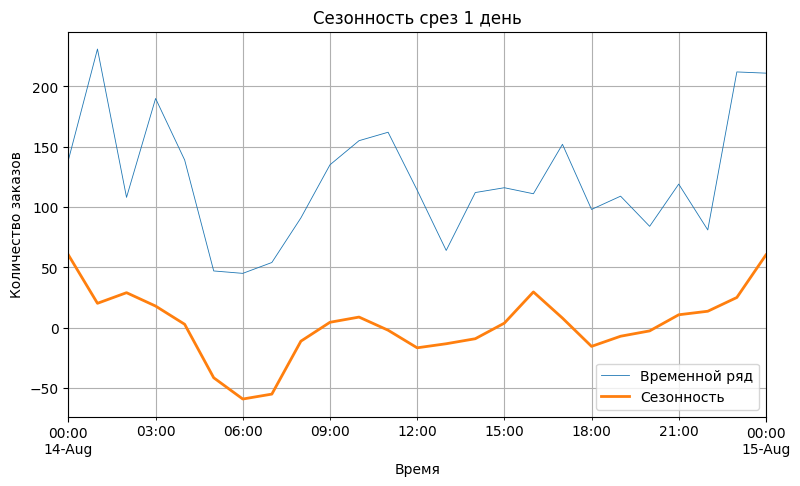

In [15]:
# выберем один день - вторник
one_day = df['2018-08-14 00:00:00':'2018-08-15 00:00:00'].index
# временной ряд
df.loc[one_day]['num_orders'].plot(linewidth=0.6)
# построим график сезонности
decomposed.seasonal[one_day].plot(figsize=(9,5), linewidth=2)
plt.title('Сезонность срез 1 день')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.legend(['Временной ряд',  'Сезонность'])
plt.grid(which='both')
plt.show()

Сезонность по дню обусловлена расписанием полётов регулярных рейсов:
- пик количества заказов в 0 часов - в конце дня прилетает больше рейсов
- падение к самому низкому значению в 6 утра - ночью вылетает меньше рейсов
- с 8 в течение дня средние уровень с повышениями в 9-10, 16 часов и после 21



На графике одной недели выделяеюся пики в ночи на понедельник и субботу - начало и конец рабочей недели. Попробуем посмотреть сезонность по неделям

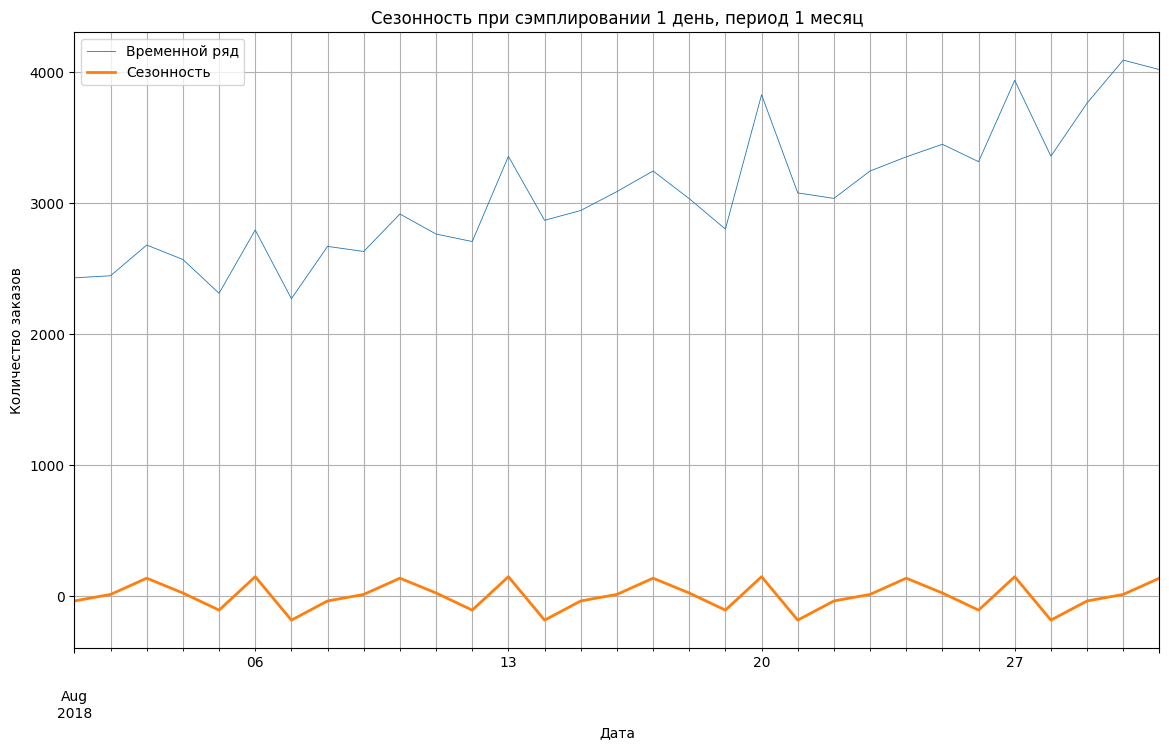

In [16]:
# временной ряд
df['2018-08-01':'2018-08-31'].resample('1D').sum()['num_orders'].plot(linewidth=0.6)
# сезонность при сэмплировании 1 день
seasonal_decompose(df['num_orders'].resample('1D').sum()).seasonal['2018-08-01':'2018-08-31'].plot(
    figsize=(14,8), title=('Сезонность при сэмплировании 1 день, период 1 месяц'),
    xlabel=('Дата'), ylabel=('Количество заказов'), linewidth=2)
plt.grid(which='both')
plt.legend(['Временной ряд',  'Сезонность'])
None

При сэмплировании суммы заказов за 1 целый день статистически также выделяется сезонность в 1 неделю, которая также обусловлена расписанием и загруженностью регулярных рейсов - в начале и конце рабочей недели пики, так как большая часть перелётов рабочие:
- минимум в вторник и воскресенье 
- максимумы в понедельник и пятницу

### Выбросы и аномальные значения
Попробуем применить инструмент ML IsolationForest для детектирования вылетов в данных.  
Одидаемой долей выбросов будет 1%

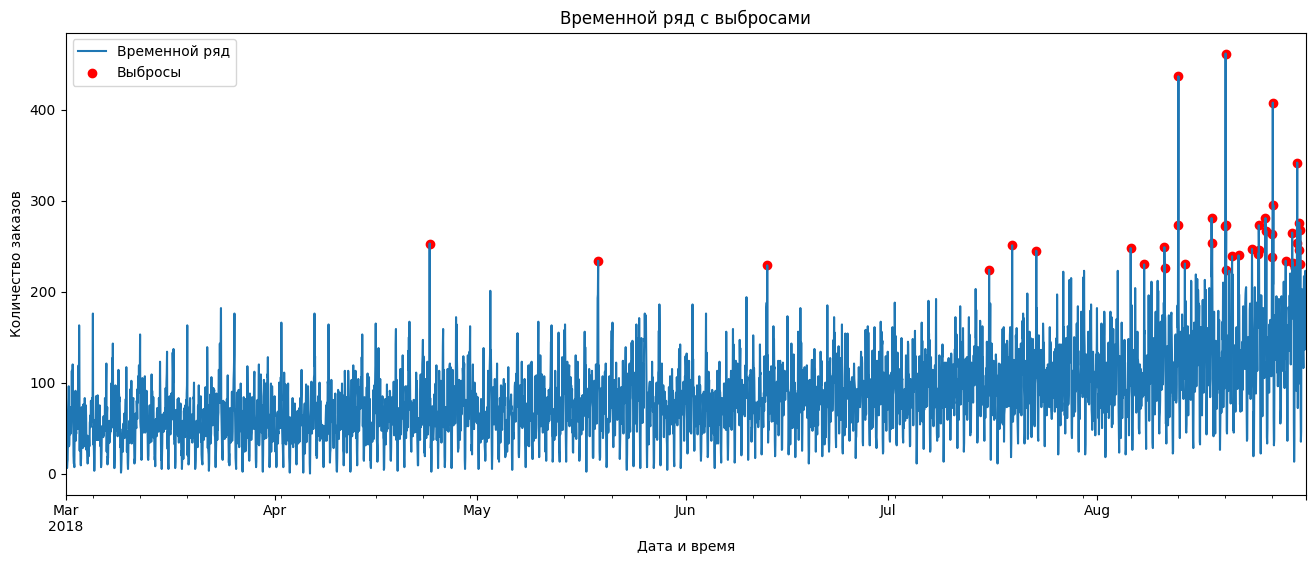

In [17]:
# Преобразование данных в numpy массив
values = df['num_orders'].values

# Обучение модели Isolation Forest для детектирования выбросов
model = IsolationForest(contamination=0.01)  # указываем ожидаемую долю выбросов
model.fit(values.reshape(-1, 1)) # reshape преобразует одномерный массив в двумерный массив с одним столбцом.

# Предсказание выбросов
outliers = model.predict(values.reshape(-1, 1))

# Извлечение выбросов из данных
outlier_values = values[outliers == -1]

# Визуализация временного ряда и выбросов
df['num_orders'].plot(figsize=(16, 6), label='Временной ряд')
plt.scatter(df[outliers == -1].index, outlier_values, color='red', label='Выбросы')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.title('Временной ряд с выбросами')
plt.legend()
plt.show()

In [18]:
# изучим характеристик выбросов
pd.Series(outlier_values).describe()

count     42.000000
mean     265.119048
std       53.523281
min      224.000000
25%      234.000000
50%      248.500000
75%      272.750000
max      462.000000
dtype: float64

1% выбросов составляет 42 записи со значениями в диапазоне 224-462 заказов.   
Выбросы сосредоточены в августе, поэтому мы не будем их трогать, так как:
- тренд заметно увеличивается в августе по сравнению с предыдущими месяцами -  показывает новые закономерности периода - сымые большие вылеты повторяются каждую неделю
- август попадёт в тестовую выборку, в которой нельзя корректировать значения.

### Корреляция и новые признаки
Проверим наличие автокорреляции в ряде, то есть корреляции с "отстающими значениями" - лагами. И дополнительно создадим новые признаки:
- календарные - выделим из даты месяц, число месяца, день недели и час
- скользящие средние с разным размером окна.

Для обучения оставим календарные признаки и те, которые будут иметь корреляцию с целевым признаком.

На данный момент анализа ожидаем увидеть зависимость целевого признака с часом, днём недели, с тем же часом предыдущего дня и недели, с предыдущим часом.

In [19]:
# функция для создания новых признаков
def make_features(data, max_lag, rolling_mean_list):
    # календарные признаки 
    #data['month'] = data.index.month # в датасете неполный год 1-8 месяцы
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    # признаки с лагами
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # лаг такой же час в предыдущую неделю
    data['lag_{}'.format(24*7)] = data['num_orders'].shift(24*7)
    
    # признак скользящее среднее
    for size  in rolling_mean_list:
        data['rolling_mean_{}'.format(size)] = data['num_orders'].shift().rolling(size).mean()

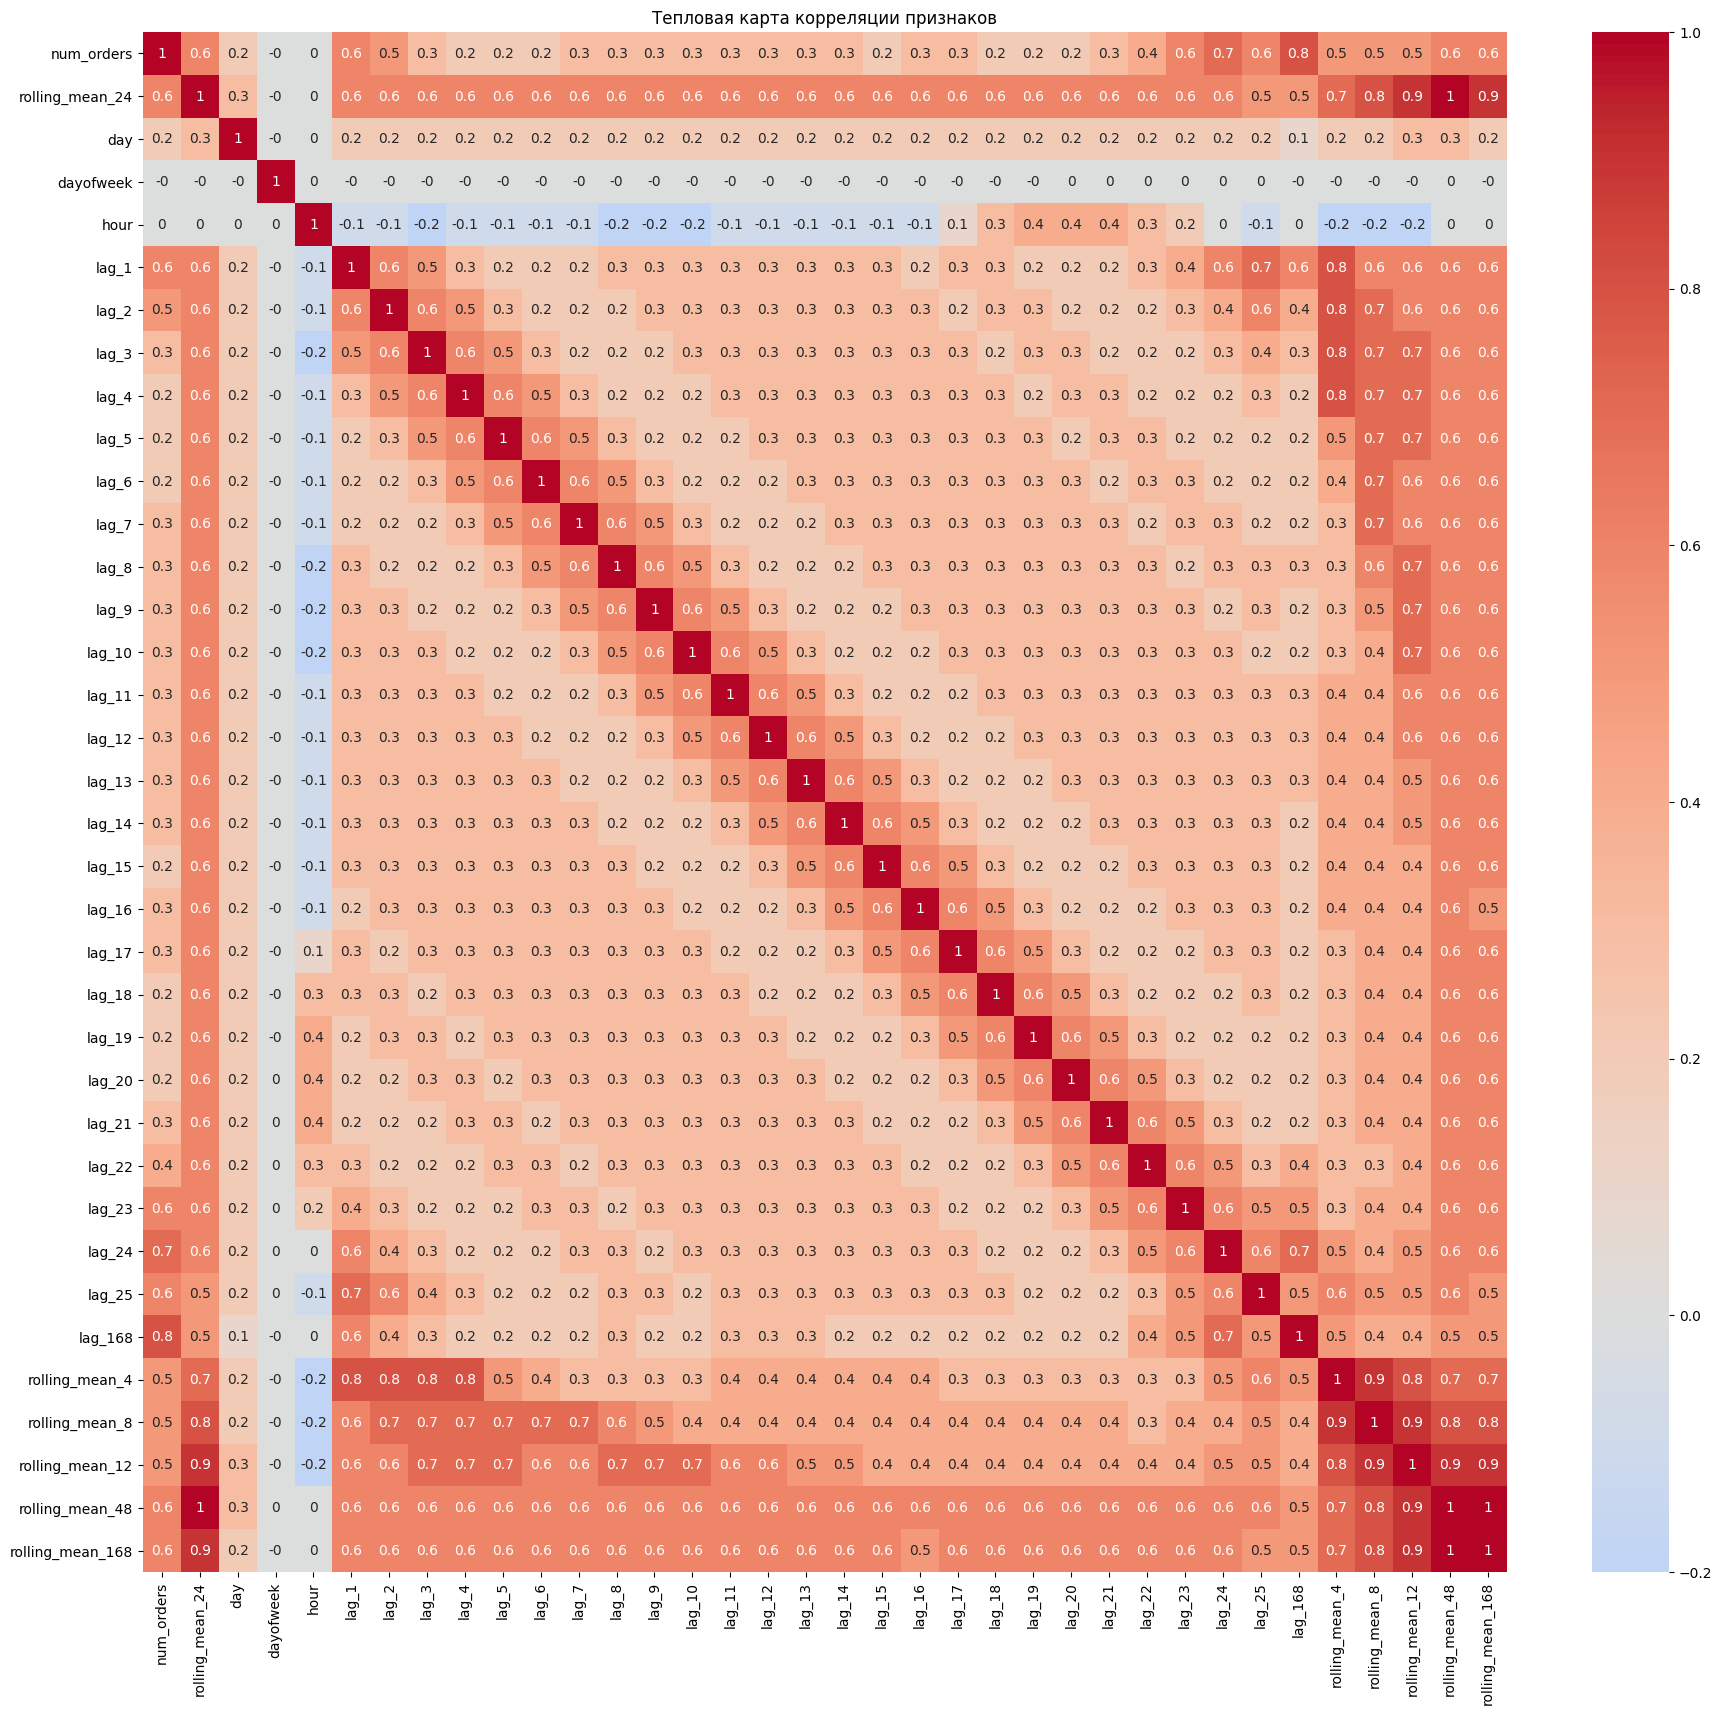

In [20]:
# создадим признаки с лагом до 25 часов
make_features(df, 25, [4, 8, 12, 24, 24*2, 24*7])

# рассчитаем и визуализируем коэффициент корреляции Пирсона
#df.corr().abs().style.background_gradient().set_precision(2)
plt.figure(figsize=(22,20))
sns.heatmap(round(df.corr(), 1), cmap='coolwarm', center=0, annot=True)
plt.title('Тепловая карта корреляции признаков')
plt.show()

Наблюдаем среднюю корреляцию (линейную зависимость) между:
- целевым признаком и:
    - скользящим средним с окном 24 часа
    - с двумя предыдущими часами
    - таким же часов в предыдущем дне
    - таким же часом в предыдущей неделе
    - предыдущим и последующем часе в предыдущем дне
- скользящим средним
- всех соседних лагов между собой

Оставляем для обучения:
- скользящее среднее с окном 24 часа: rolling_mean_24
- два предыдущих часа: lag_1, lag_2,
- лаги с 23, 24, 25, 168 часами: lag_23, lag_24, lag_25, lag_168
- календарные признаки: число, день недели, час



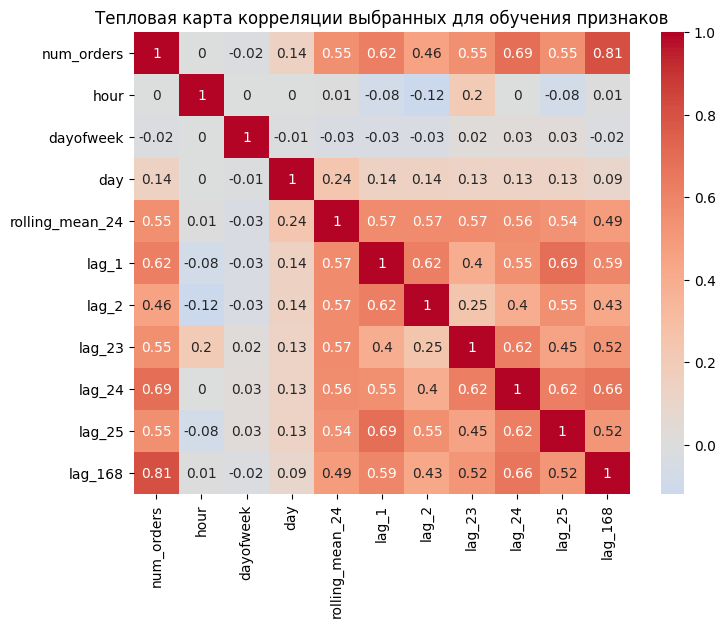

In [21]:
# признаки для обучения
features = ['num_orders', 
            'hour', 'dayofweek', 'day',
            'rolling_mean_24', 
            'lag_1', 'lag_2', 'lag_23', 'lag_24', 'lag_25', 'lag_168']

# оставим в датасете только нужные признаки
df = df[features]

# удалим строки с пропусками, которые образовались при создании новых признаков в начале
df = df.dropna()

# check
plt.figure(figsize=(8,6))
sns.heatmap(round(df.corr(), 2), cmap='coolwarm', center=0, annot=True)
plt.title('Тепловая карта корреляции выбранных для обучения признаков')
plt.show()

**Итоги анализа:**. 
Мы исследовали временной ряд с января по август 2018 года с количеством заказов такси из аэропорта. Выявлены закономерности:
- Временной ряд имеет общий тренд увеличения числа заказов, повышение сильнее в летний сезон - сезон отпусков
- В августе увеличение более резкое  - период возвращения из отпусков
- Временной ряд имеет сезонности: 
    - период 1 день -  обусловлена расписанием полётов регулярных рейсов, 
    - период 1 неделя - также расписанием и загруженностью рейсов - в начале и конце рабочей недели пики, так как большая часть перелётов рабочие.
- Статистически имеются выбросы из общего распределения, они сосредоточены в августе. Наличие больших значений в августе скорее всего связано с периодом возвращения из отпусков

Созданы новые признаки для обучения, с которыми целевой признак наиболее коррелирует: скользящее среднее с окном 24 часа, два предыдущих часа, лаги с 23, 24, 25 часами, лаг часа в предыдущую неделю и календарные: день недели, число и час. Месяц не используем, так как исследуемый период содержит неполный год.

---

## Обучение
Перед нами поставлена задача прогнозирования количества заказов такси в следующий час - задача регрессии, которую будем решать методом обучения с учителем.  
Протестируем 3 модели: линейную ElasticNet, градиентный бустинг CatBoost и RandomForest.

### Подготовка выборок
Преобразованный датасет разделим на обучающую 90% и тестовую 10% выборки. Данные обучающей выборки предшествуют данным тестовой.

In [22]:
# разделим данные на обучающую и тестовую выборки
train, test = train_test_split(df, test_size=0.1, shuffle=False)

In [23]:
# выделим целевой признак из выборок
X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)
y_train = train['num_orders']
y_test = test['num_orders']

# размер полученных выборок
X_train.shape, X_test.shape

((3823, 10), (425, 10))

In [24]:
X_train.shape, X_test.shape

((3823, 10), (425, 10))

### Обучение моделей
Перед нам
Обучим 3 модели с подбором гиперпараметров с кросс-валидацией с помощью RandomizedSearchCV. Для этого напишем собственную функцию

In [25]:
# для кросс-валидации временного ряда используем функцию 
ts_cv = TimeSeriesSplit(n_splits=5, test_size=len(y_test))

In [26]:
# зададим начальное состояние генератора случайности для использования в моделях и рэндомсёрче
random_state = 12345

In [68]:
# функция принимает на вход модель и диапазоны гиперпараметров
def rand_search_cv_func(model, params):
    # выполняет подбор ГП
    rs = RandomizedSearchCV(estimator=model, 
                            cv=ts_cv,
                            param_distributions=params,
                            scoring='neg_root_mean_squared_error',
                            verbose=1,
                            n_iter=30,
                            random_state=random_state
                     )
    rs.fit(X_train, y_train)
    # возвращает лучшую  модель, подобранные гиперпараметры, rmse лучшей модели
    return rs.best_estimator_, rs.best_params_, -rs.best_score_, rs

In [53]:
# функция для вывода результатов функции с RandomizedSearchCV
def results_func(result):
    return print(f"""Модель: {result[0]} 
Гиперпараметры: {result[1]} 
RMSE на кросс-валидации: {result[2]:.2f}""")

#### Линейная регрессия с регуляризацией Elasticnet

In [69]:
# определяем модель
model_elastic = ElasticNet(random_state=random_state)

# диапазоны гиперпараметров для ElasticNet
params_elastic = {'alpha' : np.arange(0.001, 1, 0.05),
                  'l1_ratio' : [ 0.25, 0.5, 0.75, 1],
                 'max_iter' : [10, 50, 100, 200, 300, 500]} 

# обучение, метрика, подбор ГП
elastic = rand_search_cv_func(model_elastic, params_elastic)

# результаты RandomizedSearchCV
results_func(elastic)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Модель: ElasticNet(alpha=0.8510000000000001, l1_ratio=1, max_iter=10,
           random_state=12345) 
Гиперпараметры: {'max_iter': 10, 'l1_ratio': 1, 'alpha': 0.8510000000000001} 
RMSE на кросс-валидации: 24.66


#### Градиентный бустинг CatBoost

In [55]:
# модель градиентный бустинг из catboost и диапазон ГП для подбора
model_gbc = cb.CatBoostRegressor(random_state=random_state, silent=True)
params_gcb = {
              'max_depth' : [None] + list(range(1,13)),
              'iterations' : [50, 100, 150, 200],
              'learning_rate': np.arange(0, 1.1, 0.1) } 

# обучение, метрика, подбор ГП
gbc = rand_search_cv_func(model_gbc, params_gcb)

# результаты 
results_func(gbc)

Fitting 5 folds for each of 572 candidates, totalling 2860 fits


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Модель: <catboost.core.CatBoostRegressor object at 0x7fb3c37151f0> 
Гиперпараметры: {'max_depth': 4, 'learning_rate': 0.1, 'iterations': 100} 
RMSE на кросс-валидации: 24.16


#### Случайный лес

In [56]:
# определяем модель, задаём диапазоны ГП
model_rfr = RandomForestRegressor(random_state=random_state, n_jobs=-1)

params_rfr = {#'random_state' : [42],
              'max_depth' : [None] + list(range(1,13)), 
              'n_estimators' : [100, 200],
             }

# обучение, метрика, подбор ГП
rfr = rand_search_cv_func(model_rfr, params_rfr)

# вывод результатов подбора
results_func(rfr)

Fitting 5 folds for each of 26 candidates, totalling 130 fits
Модель: RandomForestRegressor(max_depth=9, n_estimators=200, n_jobs=-1,
                      random_state=12345) 
Гиперпараметры: {'n_estimators': 200, 'max_depth': 9} 
RMSE на кросс-валидации: 24.71


In [61]:
# сводная таблица с результатами
results_table = pd.DataFrame([elastic[2], gbc[2], rfr[2]], 
             columns=['RMSE_cv'],
            index=['ElasticNet', 'CatBoost', 'RandomForest'])
             
results_table.style.set_precision(2)

,RMSE_cv
ElasticNet,24.66
CatBoost,24.16
RandomForest,24.71


Лучшей моделью среди трёх с  павнозначными значениями метрики качества выбираем линейную ElasticNet:  за счёт скорости работы и интерпритируемости.

## Тестирование
**1. Прогнозирование**

Протестируем выбранную модель ElasticNet на тестовой выборке, рассчитаем RMSE

In [58]:
# рассчет rmse на тесте, добавление в сводную таблицу
results_table.loc['ElasticNet', 'RMSE_test'] = mean_squared_error(y_test, elastic[0].predict(X_test), squared=False)

# выведем таблицу
results_table.style.set_precision(2)

,RMSE_cv,RMSE_test
ElasticNet,24.66,34.75
CatBoost,24.16,nan
RandomForest,24.71,nan


Предсказания на тестовой выборке показывают, что в среднем модель ошибается на 34 заказа. Ошибка заметная, скорее всего, большой вклад в её расчёт вносят августовские "выбросы". Относительно результатов кросс-валидации отклонение приемлемо. Условия задания выполнены - метрика ниже 48.

Визуализируем отличия предсказаний и реальных значений тестовой выборки

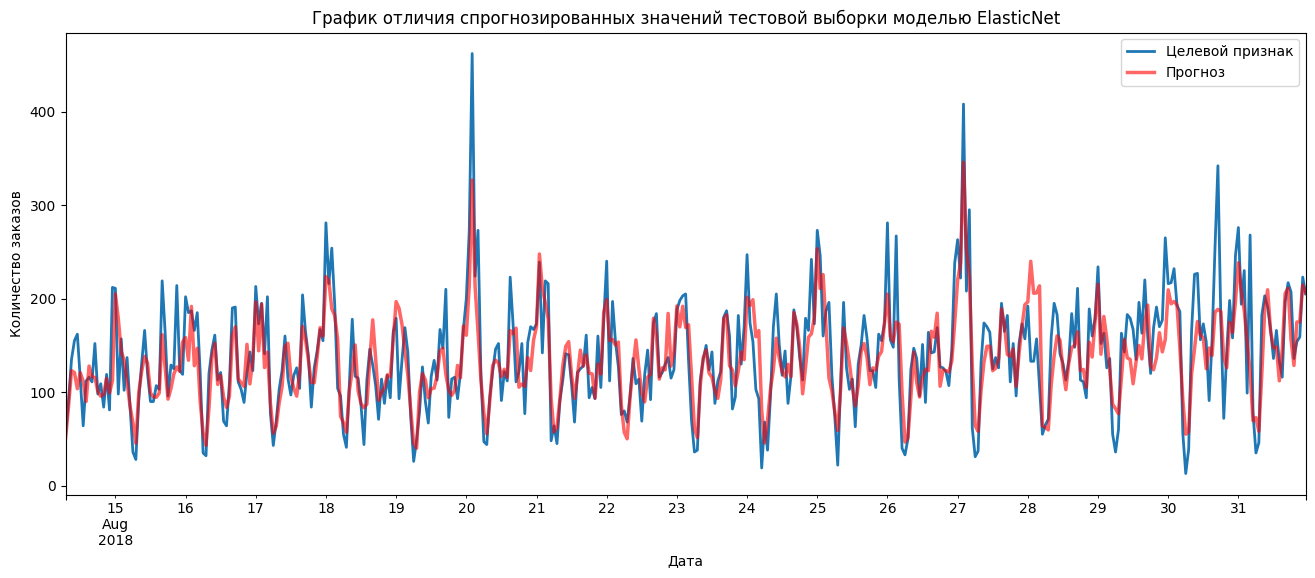

In [60]:
# график реальных значений целевого признака тестовой выборки
y_test.plot(figsize=(16,6),  linewidth=2, label='Целевой признак')
# график предсказанных значений тестовой выбоки моделью ElasticNet
pd.Series(elastic[0].predict(X_test), y_test.index).plot(alpha=0.6, linewidth=2.5, color='r', label='Прогноз')
plt.title('График отличия спрогнозированных значений тестовой выборки моделью ElasticNet')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend();

На графике видно, что в общем модель правильно предсказывает колебания, но ошибается в амплитуде - более низкая, чем реальная, особенно в "выбросах", как и ожидалось. 

Известно, что есть ежегодная цикличность, которая отражает поведение в конкретные периоды года. Могли ли улучшить наш прогноз данные за предыдущие годы?

**2. Тест на адекватность**

Для оценки адекватности нашей модели сравним результаты с простой моделью, которая в качестве предсказания выдаёт значение в предыдущий час

In [59]:
# сравнение с предсказанием предыдущим значением
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])
print("RMSE:", mean_squared_error(y_test, pred_previous, squared=False))

RMSE: 58.819724582830204


In [62]:
# модель с предсказанием предыдущим значением
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])

# добавим в сводную таблицу
results_table.loc['Dummy_previous', 'RMSE_test'] = mean_squared_error(y_test, pred_previous, squared=False)
results_table.style.set_precision(2)

,RMSE_cv,RMSE_test
ElasticNet,24.66,nan
CatBoost,24.16,nan
RandomForest,24.71,nan
Dummy_previous,nan,58.82


Модели предсказывают лучше, чем простая модель.

Лучшей моделью для решения задачи прогнозирования заказов такси в следующий час является линейная модель ElasticNet с гиперпараметрами:

In [70]:
# гиперпараметры выбранной модели ElasticNet
elastic[1]

{'max_iter': 10, 'l1_ratio': 1, 'alpha': 0.8510000000000001}

### Важность признаков
Посмотрим на коэффициенты линейной модели и проанализируем вклад признаков в предсказание

In [87]:
pd.DataFrame(elastic[0].coef_*100, index=elastic[0].feature_names_in_, columns=['Coef *100']).abs()\
            .sort_values(by='Coef *100', ascending=False).style.background_gradient().set_precision(2)

,Coef *100
lag_168,54.63
lag_24,20.52
lag_1,13.29
day,8.07
lag_23,6.67
rolling_mean_24,6.10
lag_2,3.76
dayofweek,2.83
hour,2.25
lag_25,1.91


Наиболее значимый вклад в предсказании на следующий час имеют такой же час неделю назад `lag_168` и такой же час в предыдущие сутки `lag_24`, далее предыдущий час.

___

## Итоги

Перед нами была поставлена задача прогнозирования количества заказов такси из аэропорта в следующий час.  

Для исследования даны исторические данные за 6 месяцев за период 2018-03-01 - 2018-08-31. Данные корректные и полные, представляют собой количество заказов такси каждые 10 минут.

В результате анализа выявлены закономерности в указанный период и предположены причены:
- Возрастающий тренд - связан с увеличением перелётов в летний период, а более резкое повышение и выбивающиеся высокие значения в августе - с периодом возвращения из отпусков
- Сезонность по дню - связана с расписанием регулярных рейсов 
- Сезонность по неделе - связана с расписанием и активностью в рабочую неделю: пики в понедельник и пятницу

Для обучения моделей сгенерированы признаки: скользящее среднее с окном 24 часа, лаги на 1, 2, 24, 25, 168 часов (тот же час в предыдущую неделю), календарные - число, день недели, час.

Для решения задачи протестировано 3 модели машинного обучения: линейная ElasticNet, градиентный бустинг CatBoost и RandomForest. Модели показали равнозначный результат на кросс-валидации по установленной метрике качества RMSE.   
**Лучший выбрана линейная модель ElasticNet**, которая имеет более высокую интерпретируемость работы алгоритма. Залданное условие качества модели достигнуто - RMSE  на тестовой выборке ниже 48.
